In [2]:
import pandas as pd
import protfasta
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import os
import urllib.parse
import urllib.request
from concurrent.futures import ThreadPoolExecutor, as_completed
import time

# Preparing input script

In [4]:
interpro = pd.read_csv("../data/interpro_tf_doms_7-22-25.csv")
interpro["Interpro superfamily domain code"] = interpro["Interpro superfamily domain code"].str.strip().fillna(interpro["Interpro domain code"])
interpro_codes = interpro["Interpro superfamily domain code"].drop_duplicates()
interpro_codes

0     IPR036236
2     IPR009057
3     IPR036638
4     IPR046347
5     IPR036388
6     IPR035500
7     IPR036910
9     IPR036960
10    IPR017956
11    IPR010982
13    IPR038441
14    IPR006600
16    IPR003656
17    IPR013088
18    IPR008967
19    IPR008984
20    IPR010919
21    IPR002857
23    IPR016177
26    IPR036407
28    IPR012345
29    IPR036431
30    IPR057520
31    IPR036879
32    IPR012340
33    IPR013854
34    IPR038096
35    IPR038538
36    IPR038173
38    IPR036647
39    IPR041686
40    IPR006578
41    IPR012295
44    IPR037095
47    IPR000967
49    IPR036115
50    IPR005559
51    IPR033467
52    IPR018586
53    IPR003958
54    IPR007588
Name: Interpro superfamily domain code, dtype: object

In [5]:
len(interpro_codes)

41

In [11]:
# # List of InterPro IDs to fetch
# ipr_ids = interpro_codes #["IPR036236"]  # Replace/add your IPR IDs here

# # Output directory
# os.makedirs("../output/interpro/uniprot/", exist_ok=True)

# # UniProt REST API base
# base_url = "https://rest.uniprot.org/uniprotkb/stream"

# for ipr_id in ipr_ids:
#     # Create UniProt query for existence:1
#     query = f"({ipr_id}) AND (existence:1)Z
#     encoded_query = urllib.parse.quote(query)

#     # Construct URL
#     full_url = f"{base_url}?compressed=true&format=fasta&query={encoded_query}"

#     # Output file path
#     output_file = f"../data/interpro_uniprot_downloads/{ipr_id}.fasta.gz"

#     # Download
#     try:
#         print(f"Downloading: {ipr_id}...")
#         urllib.request.urlretrieve(full_url, output_file)
#         print(f"Saved: {output_file}")
#     except Exception as e:
#         print(f"Error downloading {ipr_id}: {e}")

#     time.sleep(1)  # polite delay

In [1]:
# # Now also getting transcript evidence 

# # List of IPR IDs to query
# ipr_ids = interpro_codes  # Replace or add more

# # Output folder
# os.makedirs("../data/interpro_uniprot_downloads/transcript_evidence/", exist_ok=True)

# # Base URL
# base_url = "https://rest.uniprot.org/uniprotkb/stream"

# for ipr_id in ipr_ids:
#     # Construct query: InterPro ID AND existence level 2
#     query = f"({ipr_id}) AND (existence:2)"
#     encoded_query = urllib.parse.quote(query)

#     # Full request URL
#     full_url = f"{base_url}?compressed=true&format=fasta&query={encoded_query}"

#     # Output file path
#     output_file = f"../data/interpro_uniprot_downloads/transcript_evidence/{ipr_id}.fasta.gz"

#     # Try downloading
#     try:
#         print(f"Downloading: {ipr_id} (existence:2)...")
#         urllib.request.urlretrieve(full_url, output_file)
#         print(f"Saved to: {output_file}")
#     except Exception as e:
#         print(f"Failed to download {ipr_id}: {e}")

#     #time.sleep(1)  # polite delay


In [38]:
# rm -r ../output/interpro/uniprot/

In [39]:
# mkdir ../output/interpro/uniprot/

In [16]:
 ! gunzip ../data/interpro_uniprot_downloads/transcript_evidence/*

# How many input sequences?

In [6]:
all_dfs = []

for path in glob.glob("../data/interpro_uniprot_downloads/IPR*"):
    fasta_dict = protfasta.read_fasta(path, invalid_sequence_action = 'remove')
    path_df = pd.DataFrame({"path" : path, "id" : fasta_dict.keys(), "seq" : fasta_dict.values(), "evidence" : "protein"})
    all_dfs.append(path_df)

for path in glob.glob("../data/interpro_uniprot_downloads/transcript_evidence/*"):
    fasta_dict = protfasta.read_fasta(path, invalid_sequence_action = 'remove')
    path_df = pd.DataFrame({"path" : path, "id" : fasta_dict.keys(), "seq" : fasta_dict.values(), "evidence" : "transcript"})
    all_dfs.append(path_df)

all_dfs = pd.concat(all_dfs)
all_dfs["Interpro superfamily domain code"] = all_dfs["path"].str.split("/").str[-1].str.split(".").str[0]
all_dfs

,path,id,seq,evidence,Interpro superfamily domain code
0,../data/interpro_uniprot_downloads/IPR007588.f...,tr|A0A0B4K6B8|A0A0B4K6B8_DROME Modifier of mdg...,MADDEQFSLCWNNFNTNLSAGFHESLCRGDLVDVSLAAEGQIVKAH...,protein,IPR007588
1,../data/interpro_uniprot_downloads/IPR007588.f...,tr|A0A0B4K7A6|A0A0B4K7A6_DROME Modifier of mdg...,MADDEQFSLCWNNFNTNLSAGFHESLCRGDLVDVSLAAEGQIVKAH...,protein,IPR007588
2,../data/interpro_uniprot_downloads/IPR007588.f...,sp|A0A5S9MMK5|FPEB1_CAEEL FLYWCH-type zinc fin...,MMTTTVQKNCWRLDQTMLGLEKPGSSDISSSSTDTSAISPISVSSM...,protein,IPR007588
3,../data/interpro_uniprot_downloads/IPR007588.f...,sp|Q4VC44|FWCH1_HUMAN FLYWCH-type zinc finger-...,MPLPEPSEQEGESVKAGQEPSPKPGTDVIPAAPRKPREFSKLVLLT...,protein,IPR007588
4,../data/interpro_uniprot_downloads/IPR007588.f...,sp|Q86B87|MMD4_DROME Modifier of mdg4 OS=Droso...,MADDEQFSLCWNNFNTNLSAGFHESLCRGDLVDVSLAAEGQIVKAH...,protein,IPR007588
...,...,...,...,...,...
5736,../data/interpro_uniprot_downloads/transcript_...,tr|W8C846|W8C846_CERCA (Mediterranean fruit fl...,MNNITRLLANCTLNTTRCHLKYNAAALTAAIQLRGKCKVVVKPAPG...,transcript,IPR012340
5737,../data/interpro_uniprot_downloads/transcript_...,tr|W8CA25|W8CA25_CERCA (Mediterranean fruit fl...,MAGRPRRQAATRTAQIIEISDSEDDNSVSKNKRRRRDSSFSPPPTK...,transcript,IPR012340
5738,../data/interpro_uniprot_downloads/transcript_...,tr|W8QUS6|W8QUS6_MIMNO Cold shock domain prote...,MSDSEKQPEEKEEPKKNVIATKVTGTVKWFNVKSGYGFINRDDTKE...,transcript,IPR012340
5739,../data/interpro_uniprot_downloads/transcript_...,tr|X5CQH7|X5CQH7_9EUKA 30S plastidal ribosomal...,MSSARPLVLIASLLGASEALQSCHTRLVSSRVAATPRAAWALTMCD...,transcript,IPR012340


In [8]:
# Drop dups 
all_dfs = all_dfs.drop_duplicates(subset = "seq")
all_dfs

,path,id,seq,evidence,Interpro superfamily domain code
0,../data/interpro_uniprot_downloads/IPR007588.f...,tr|A0A0B4K6B8|A0A0B4K6B8_DROME Modifier of mdg...,MADDEQFSLCWNNFNTNLSAGFHESLCRGDLVDVSLAAEGQIVKAH...,protein,IPR007588
1,../data/interpro_uniprot_downloads/IPR007588.f...,tr|A0A0B4K7A6|A0A0B4K7A6_DROME Modifier of mdg...,MADDEQFSLCWNNFNTNLSAGFHESLCRGDLVDVSLAAEGQIVKAH...,protein,IPR007588
2,../data/interpro_uniprot_downloads/IPR007588.f...,sp|A0A5S9MMK5|FPEB1_CAEEL FLYWCH-type zinc fin...,MMTTTVQKNCWRLDQTMLGLEKPGSSDISSSSTDTSAISPISVSSM...,protein,IPR007588
3,../data/interpro_uniprot_downloads/IPR007588.f...,sp|Q4VC44|FWCH1_HUMAN FLYWCH-type zinc finger-...,MPLPEPSEQEGESVKAGQEPSPKPGTDVIPAAPRKPREFSKLVLLT...,protein,IPR007588
4,../data/interpro_uniprot_downloads/IPR007588.f...,sp|Q86B87|MMD4_DROME Modifier of mdg4 OS=Droso...,MADDEQFSLCWNNFNTNLSAGFHESLCRGDLVDVSLAAEGQIVKAH...,protein,IPR007588
...,...,...,...,...,...
5736,../data/interpro_uniprot_downloads/transcript_...,tr|W8C846|W8C846_CERCA (Mediterranean fruit fl...,MNNITRLLANCTLNTTRCHLKYNAAALTAAIQLRGKCKVVVKPAPG...,transcript,IPR012340
5737,../data/interpro_uniprot_downloads/transcript_...,tr|W8CA25|W8CA25_CERCA (Mediterranean fruit fl...,MAGRPRRQAATRTAQIIEISDSEDDNSVSKNKRRRRDSSFSPPPTK...,transcript,IPR012340
5738,../data/interpro_uniprot_downloads/transcript_...,tr|W8QUS6|W8QUS6_MIMNO Cold shock domain prote...,MSDSEKQPEEKEEPKKNVIATKVTGTVKWFNVKSGYGFINRDDTKE...,transcript,IPR012340
5739,../data/interpro_uniprot_downloads/transcript_...,tr|X5CQH7|X5CQH7_9EUKA 30S plastidal ribosomal...,MSSARPLVLIASLLGASEALQSCHTRLVSSRVAATPRAAWALTMCD...,transcript,IPR012340


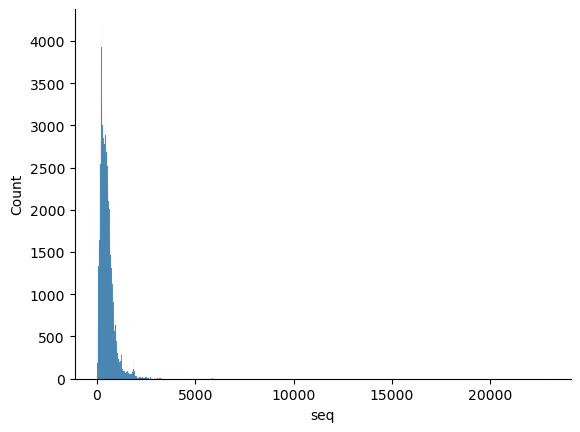

In [17]:
#How are the sequences lengths distributed?
sns.histplot(all_dfs["seq"].str.len())
sns.despine()
# Centered around 450 roughly, most are under1000 seqs

In [18]:
protfasta.write_fasta(dict(zip(all_dfs["id"], all_dfs["seq"])), "../output/interpro_uniprot_evid_1_2.fasta")

In [5]:
all_dfs["evidence"].value_counts()

evidence
transcript    78258
protein       59178
Name: count, dtype: int64

In [6]:
# Keep rows with desired codes
seqs_with_codes = pd.merge(all_dfs, interpro, on = "Interpro superfamily domain code")
seqs_with_codes["name"] = seqs_with_codes["id"].str.split("|").str[2]
seqs_with_codes["Interpro domain name shortened"] = seqs_with_codes["Interpro domain name"].str.replace(" domain", "")
seqs_with_codes = seqs_with_codes.drop_duplicates(subset = "seq")
seqs_with_codes

,path,id,seq,evidence,Interpro superfamily domain code,DBD Family,Interpro domain name,Interpro domain code,Interpro superfamily name,name,Interpro domain name shortened
0,../data/interpro_uniprot_downloads/IPR038173.f...,sp|O08791|COE3_MOUSE Transcription factor COE3...,MFGIQENIPRGGTTMKEEPLGSGMNPVRSWMHTAGVVDANTAAQSG...,protein,IPR038173,EBF1,"Transcription factor COE, DNA-binding domain",IPR032200,"Transcription factor COE, DNA-binding domain s...",COE3_MOUSE Transcription factor COE3 OS=Mus mu...,"Transcription factor COE, DNA-binding"
1,../data/interpro_uniprot_downloads/IPR038173.f...,sp|O08792|COE2_MOUSE Transcription factor COE2...,MFGIQDTLGRGPALKDKSLGAEMDSVRSWVRNVGVVDANVAAQSGV...,protein,IPR038173,EBF1,"Transcription factor COE, DNA-binding domain",IPR032200,"Transcription factor COE, DNA-binding domain s...",COE2_MOUSE Transcription factor COE2 OS=Mus mu...,"Transcription factor COE, DNA-binding"
2,../data/interpro_uniprot_downloads/IPR038173.f...,sp|Q07802|COE1_MOUSE Transcription factor COE1...,MFGIQESIQRSGSSMKEEPLGSGMNAVRTWMQGAGVLDANTAAQSG...,protein,IPR038173,EBF1,"Transcription factor COE, DNA-binding domain",IPR032200,"Transcription factor COE, DNA-binding domain s...",COE1_MOUSE Transcription factor COE1 OS=Mus mu...,"Transcription factor COE, DNA-binding"
3,../data/interpro_uniprot_downloads/IPR038173.f...,sp|Q63398|COE1_RAT Transcription factor COE1 O...,MFGIQESIQRSGSSMKEEPLGSGMNAVRTWMQGAGVLDANTAAQSG...,protein,IPR038173,EBF1,"Transcription factor COE, DNA-binding domain",IPR032200,"Transcription factor COE, DNA-binding domain s...",COE1_RAT Transcription factor COE1 OS=Rattus n...,"Transcription factor COE, DNA-binding"
4,../data/interpro_uniprot_downloads/IPR038173.f...,sp|Q93705|UNC3_CAEEL Transcription factor unc-...,MSLTAPLRAGQMNFYDEPYNPVLNLHIQPSVKDENQRSTWPIIDTS...,protein,IPR038173,EBF1,"Transcription factor COE, DNA-binding domain",IPR032200,"Transcription factor COE, DNA-binding domain s...",UNC3_CAEEL Transcription factor unc-3 OS=Caeno...,"Transcription factor COE, DNA-binding"
...,...,...,...,...,...,...,...,...,...,...,...
342705,../data/interpro_uniprot_downloads/transcript_...,tr|A0A411G830|A0A411G830_9HYME HTH CENPB-type ...,VRRFIINIDILFSFFDSSFVLYSKMTDSNSNANYQVMDLNSNDVTS...,transcript,IPR006600,CENPB,HTH CenpB-type DNA-binding domain,IPR006600,NaN,A0A411G830_9HYME HTH CENPB-type domain-contain...,HTH CenpB-type DNA-binding
342706,../data/interpro_uniprot_downloads/transcript_...,tr|A0A6F9DP70|A0A6F9DP70_9ASCI Uncharacterized...,MEEKATASPKTPGFRKIFSVNEEEIIGKFLISCWKKKLRVPNEVLF...,transcript,IPR006600,CENPB,HTH CenpB-type DNA-binding domain,IPR006600,NaN,A0A6F9DP70_9ASCI Uncharacterized protein zf(C2...,HTH CenpB-type DNA-binding
342707,../data/interpro_uniprot_downloads/transcript_...,tr|A0A8E6LR96|A0A8E6LR96_9HYPO CENP-B-like pro...,MADSTTDPALVAAEPTDIPSVPAPASASSKERNSLTLDQRRALRRW...,transcript,IPR006600,CENPB,HTH CenpB-type DNA-binding domain,IPR006600,NaN,A0A8E6LR96_9HYPO CENP-B-like protein (Fragment...,HTH CenpB-type DNA-binding
342708,../data/interpro_uniprot_downloads/transcript_...,tr|T1PL60|T1PL60_MUSDO Regulator of RNA polyme...,MYDELPVYQRVASAFKCSWEQIKNVVANRKQILKYYASCQIIDVMK...,transcript,IPR006600,CENPB,HTH CenpB-type DNA-binding domain,IPR006600,NaN,T1PL60_MUSDO Regulator of RNA polymerase sigma...,HTH CenpB-type DNA-binding


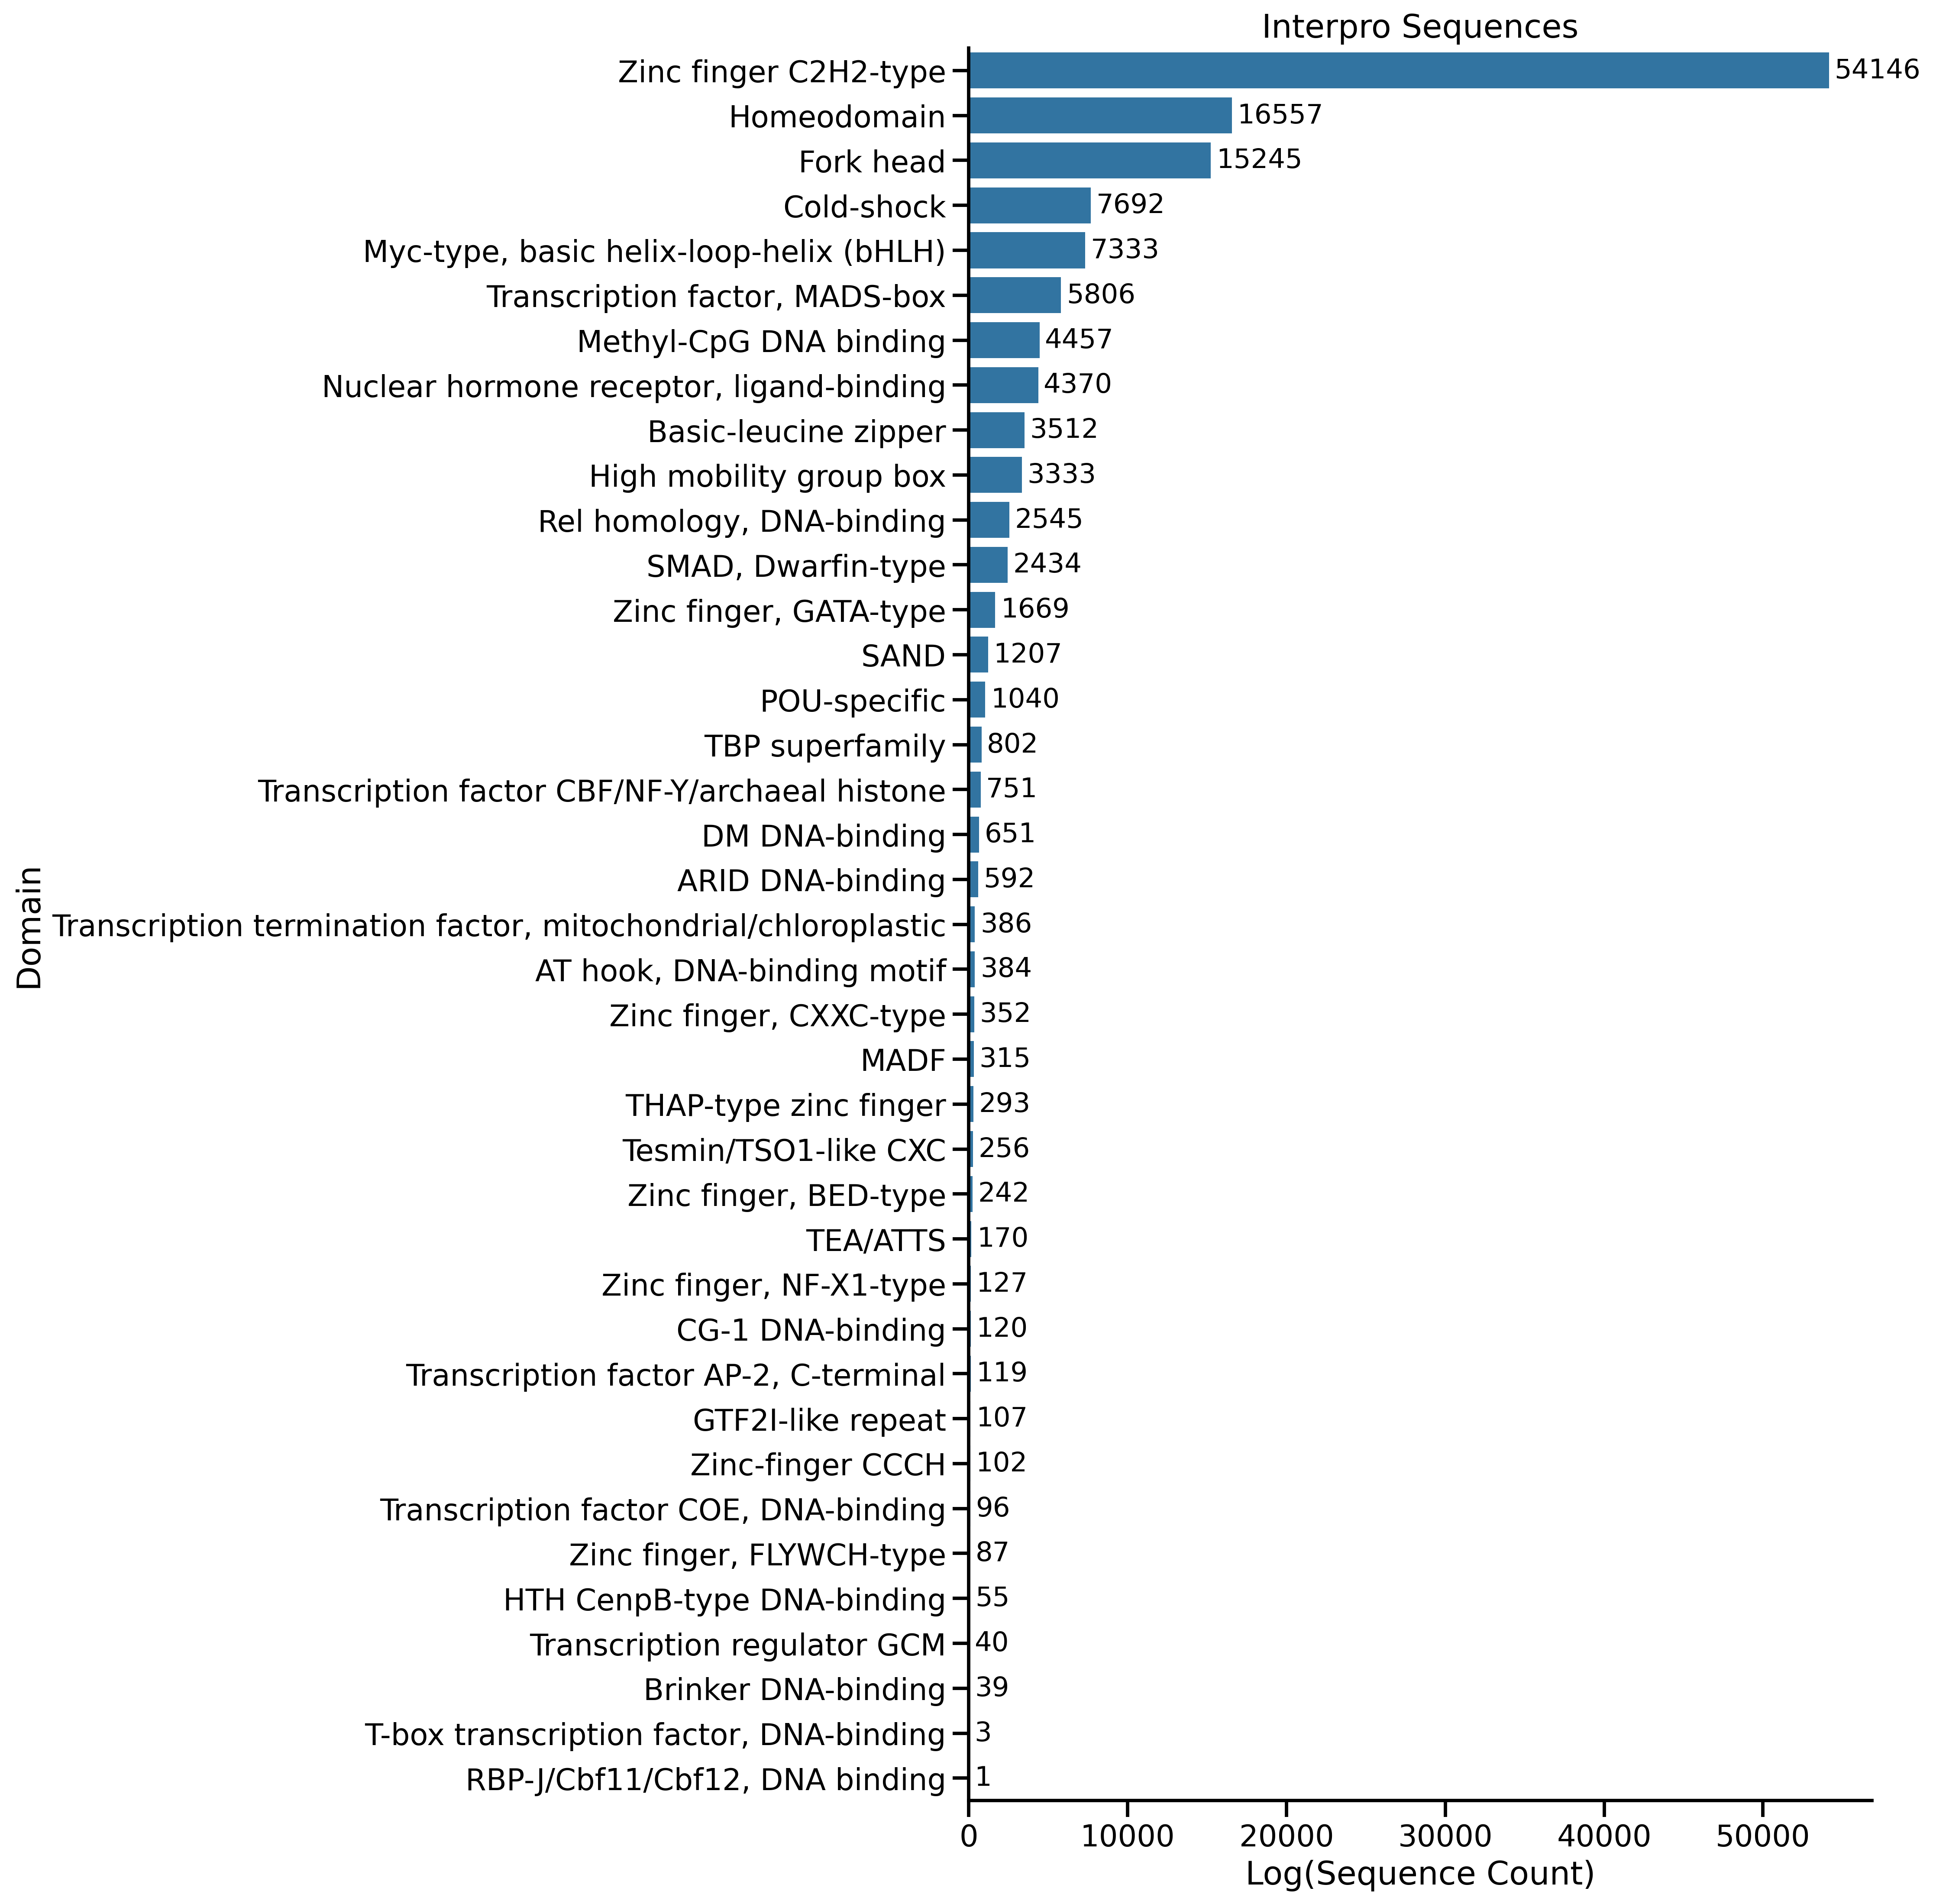

In [7]:
sns.set_context('talk')

counts = seqs_with_codes["Interpro domain name shortened"].value_counts()

plt.figure(figsize=(15, 15), dpi = 300)
ax = sns.barplot(
    y=counts.index,
    x=counts.values,
    color = sns.color_palette('tab10')[0]
)

# Set log scale for x-axis
#ax.set_xscale('log')

# # Remove top and right spines
sns.despine()

# Add labels at the end of each bar
for container in ax.containers:
    ax.bar_label(container, labels=[f"{int(v)}" for v in container.datavalues],
                 label_type='edge', fontsize='small', padding=3)

# Axis labels
plt.xlabel("Log(Sequence Count)")
plt.ylabel("")
plt.title("Interpro Sequences")
plt.ylabel("Domain")

plt.tight_layout()
plt.show()


# What species?

In [8]:
seqs_with_codes["name"].iloc[0]

'COE3_MOUSE Transcription factor COE3 OS=Mus musculus OX=10090 GN=Ebf3 PE=1 SV=1'

In [9]:
seqs_with_codes["id"].iloc[0]

'sp|O08791|COE3_MOUSE Transcription factor COE3 OS=Mus musculus OX=10090 GN=Ebf3 PE=1 SV=1'

# What species?

In [10]:
seqs_with_codes["uniprotID"] = seqs_with_codes["id"].str.split("|").str[1]
seqs_with_codes

,path,id,seq,evidence,Interpro superfamily domain code,DBD Family,Interpro domain name,Interpro domain code,Interpro superfamily name,name,Interpro domain name shortened,uniprotID
0,../data/interpro_uniprot_downloads/IPR038173.f...,sp|O08791|COE3_MOUSE Transcription factor COE3...,MFGIQENIPRGGTTMKEEPLGSGMNPVRSWMHTAGVVDANTAAQSG...,protein,IPR038173,EBF1,"Transcription factor COE, DNA-binding domain",IPR032200,"Transcription factor COE, DNA-binding domain s...",COE3_MOUSE Transcription factor COE3 OS=Mus mu...,"Transcription factor COE, DNA-binding",O08791
1,../data/interpro_uniprot_downloads/IPR038173.f...,sp|O08792|COE2_MOUSE Transcription factor COE2...,MFGIQDTLGRGPALKDKSLGAEMDSVRSWVRNVGVVDANVAAQSGV...,protein,IPR038173,EBF1,"Transcription factor COE, DNA-binding domain",IPR032200,"Transcription factor COE, DNA-binding domain s...",COE2_MOUSE Transcription factor COE2 OS=Mus mu...,"Transcription factor COE, DNA-binding",O08792
2,../data/interpro_uniprot_downloads/IPR038173.f...,sp|Q07802|COE1_MOUSE Transcription factor COE1...,MFGIQESIQRSGSSMKEEPLGSGMNAVRTWMQGAGVLDANTAAQSG...,protein,IPR038173,EBF1,"Transcription factor COE, DNA-binding domain",IPR032200,"Transcription factor COE, DNA-binding domain s...",COE1_MOUSE Transcription factor COE1 OS=Mus mu...,"Transcription factor COE, DNA-binding",Q07802
3,../data/interpro_uniprot_downloads/IPR038173.f...,sp|Q63398|COE1_RAT Transcription factor COE1 O...,MFGIQESIQRSGSSMKEEPLGSGMNAVRTWMQGAGVLDANTAAQSG...,protein,IPR038173,EBF1,"Transcription factor COE, DNA-binding domain",IPR032200,"Transcription factor COE, DNA-binding domain s...",COE1_RAT Transcription factor COE1 OS=Rattus n...,"Transcription factor COE, DNA-binding",Q63398
4,../data/interpro_uniprot_downloads/IPR038173.f...,sp|Q93705|UNC3_CAEEL Transcription factor unc-...,MSLTAPLRAGQMNFYDEPYNPVLNLHIQPSVKDENQRSTWPIIDTS...,protein,IPR038173,EBF1,"Transcription factor COE, DNA-binding domain",IPR032200,"Transcription factor COE, DNA-binding domain s...",UNC3_CAEEL Transcription factor unc-3 OS=Caeno...,"Transcription factor COE, DNA-binding",Q93705
...,...,...,...,...,...,...,...,...,...,...,...,...
342705,../data/interpro_uniprot_downloads/transcript_...,tr|A0A411G830|A0A411G830_9HYME HTH CENPB-type ...,VRRFIINIDILFSFFDSSFVLYSKMTDSNSNANYQVMDLNSNDVTS...,transcript,IPR006600,CENPB,HTH CenpB-type DNA-binding domain,IPR006600,NaN,A0A411G830_9HYME HTH CENPB-type domain-contain...,HTH CenpB-type DNA-binding,A0A411G830
342706,../data/interpro_uniprot_downloads/transcript_...,tr|A0A6F9DP70|A0A6F9DP70_9ASCI Uncharacterized...,MEEKATASPKTPGFRKIFSVNEEEIIGKFLISCWKKKLRVPNEVLF...,transcript,IPR006600,CENPB,HTH CenpB-type DNA-binding domain,IPR006600,NaN,A0A6F9DP70_9ASCI Uncharacterized protein zf(C2...,HTH CenpB-type DNA-binding,A0A6F9DP70
342707,../data/interpro_uniprot_downloads/transcript_...,tr|A0A8E6LR96|A0A8E6LR96_9HYPO CENP-B-like pro...,MADSTTDPALVAAEPTDIPSVPAPASASSKERNSLTLDQRRALRRW...,transcript,IPR006600,CENPB,HTH CenpB-type DNA-binding domain,IPR006600,NaN,A0A8E6LR96_9HYPO CENP-B-like protein (Fragment...,HTH CenpB-type DNA-binding,A0A8E6LR96
342708,../data/interpro_uniprot_downloads/transcript_...,tr|T1PL60|T1PL60_MUSDO Regulator of RNA polyme...,MYDELPVYQRVASAFKCSWEQIKNVVANRKQILKYYASCQIIDVMK...,transcript,IPR006600,CENPB,HTH CenpB-type DNA-binding domain,IPR006600,NaN,T1PL60_MUSDO Regulator of RNA polymerase sigma...,HTH CenpB-type DNA-binding,T1PL60


In [11]:
seqs_with_codes[["uniprotID"]].to_csv("../data/interpro_seq_uniprotids.csv", index = None, header = None)

In [12]:
interpro_species = pd.read_csv("../data/interpro_seq_species.txt", sep = "\t")
interpro_species = interpro_species.rename(columns = {"From" : "uniprotID"})
interpro_species = interpro_species.drop(columns = "Entry")
interpro_species

,uniprotID,Organism
0,A0A1L8FFY5,Xenopus laevis (African clawed frog)
1,A1L0Z1,Xenopus tropicalis (Western clawed frog) (Silu...
2,A7Y7W2,Gallus gallus (Chicken)
3,B3DM23,Xenopus tropicalis (Western clawed frog) (Silu...
4,B3DM25,Xenopus tropicalis (Western clawed frog) (Silu...
...,...,...
12779,Q9Y5Q3,Homo sapiens (Human)
12780,Q9Z125,Mus musculus (Mouse)
12781,Q9Z2Q8,Cricetulus griseus (Chinese hamster) (Cricetul...
12782,O82368,Arabidopsis thaliana (Mouse-ear cress)


In [13]:
seqs_with_codes["Organism"] = seqs_with_codes["id"].str.split("OS=").str[1].str.split("OX").str[0]
seqs_with_codes["Organism"].value_counts().head(15)

Organism
Homo sapiens                     6256
Mus musculus                     4554
Zea mays                         3371
Macaca mulatta                   2227
Arabidopsis thaliana             2194
Sus scrofa                       2066
Rattus norvegicus                2029
Danio rerio                      1956
Pan troglodytes                  1751
Callithrix jacchus               1746
Xenopus laevis                   1624
Drosophila melanogaster          1468
Ixodes ricinus                   1424
Gallus gallus                    1286
Oryza sativa subsp. japonica     1236
Name: count, dtype: int64

In [14]:
seqs_with_codes["Organism"].value_counts()

Organism
Homo sapiens                6256
Mus musculus                4554
Zea mays                    3371
Macaca mulatta              2227
Arabidopsis thaliana        2194
                            ... 
Nicotiana alata                1
Suaeda glauca                  1
Torenia hybrid cultivar        1
Dunaliella salina              1
Psalmopoeus cambridgei         1
Name: count, Length: 6481, dtype: int64

In [41]:
seqs_with_codes["Organism"].value_counts()[seqs_with_codes["Organism"].value_counts() > 10]

Organism
Homo sapiens                                                                             6256
Mus musculus                                                                             4554
Zea mays                                                                                 3371
Macaca mulatta                                                                           2227
Arabidopsis thaliana                                                                     2194
                                                                                         ... 
Pseudomonas putida (strain ATCC 47054 / DSM 6125 / CFBP 8728 / NCIMB 11950 / KT2440)       11
Callinectes sapidus                                                                        11
Pristina longiseta                                                                         11
Plakobranchus ocellatus                                                                    11
Erpornis zantholeuca                               

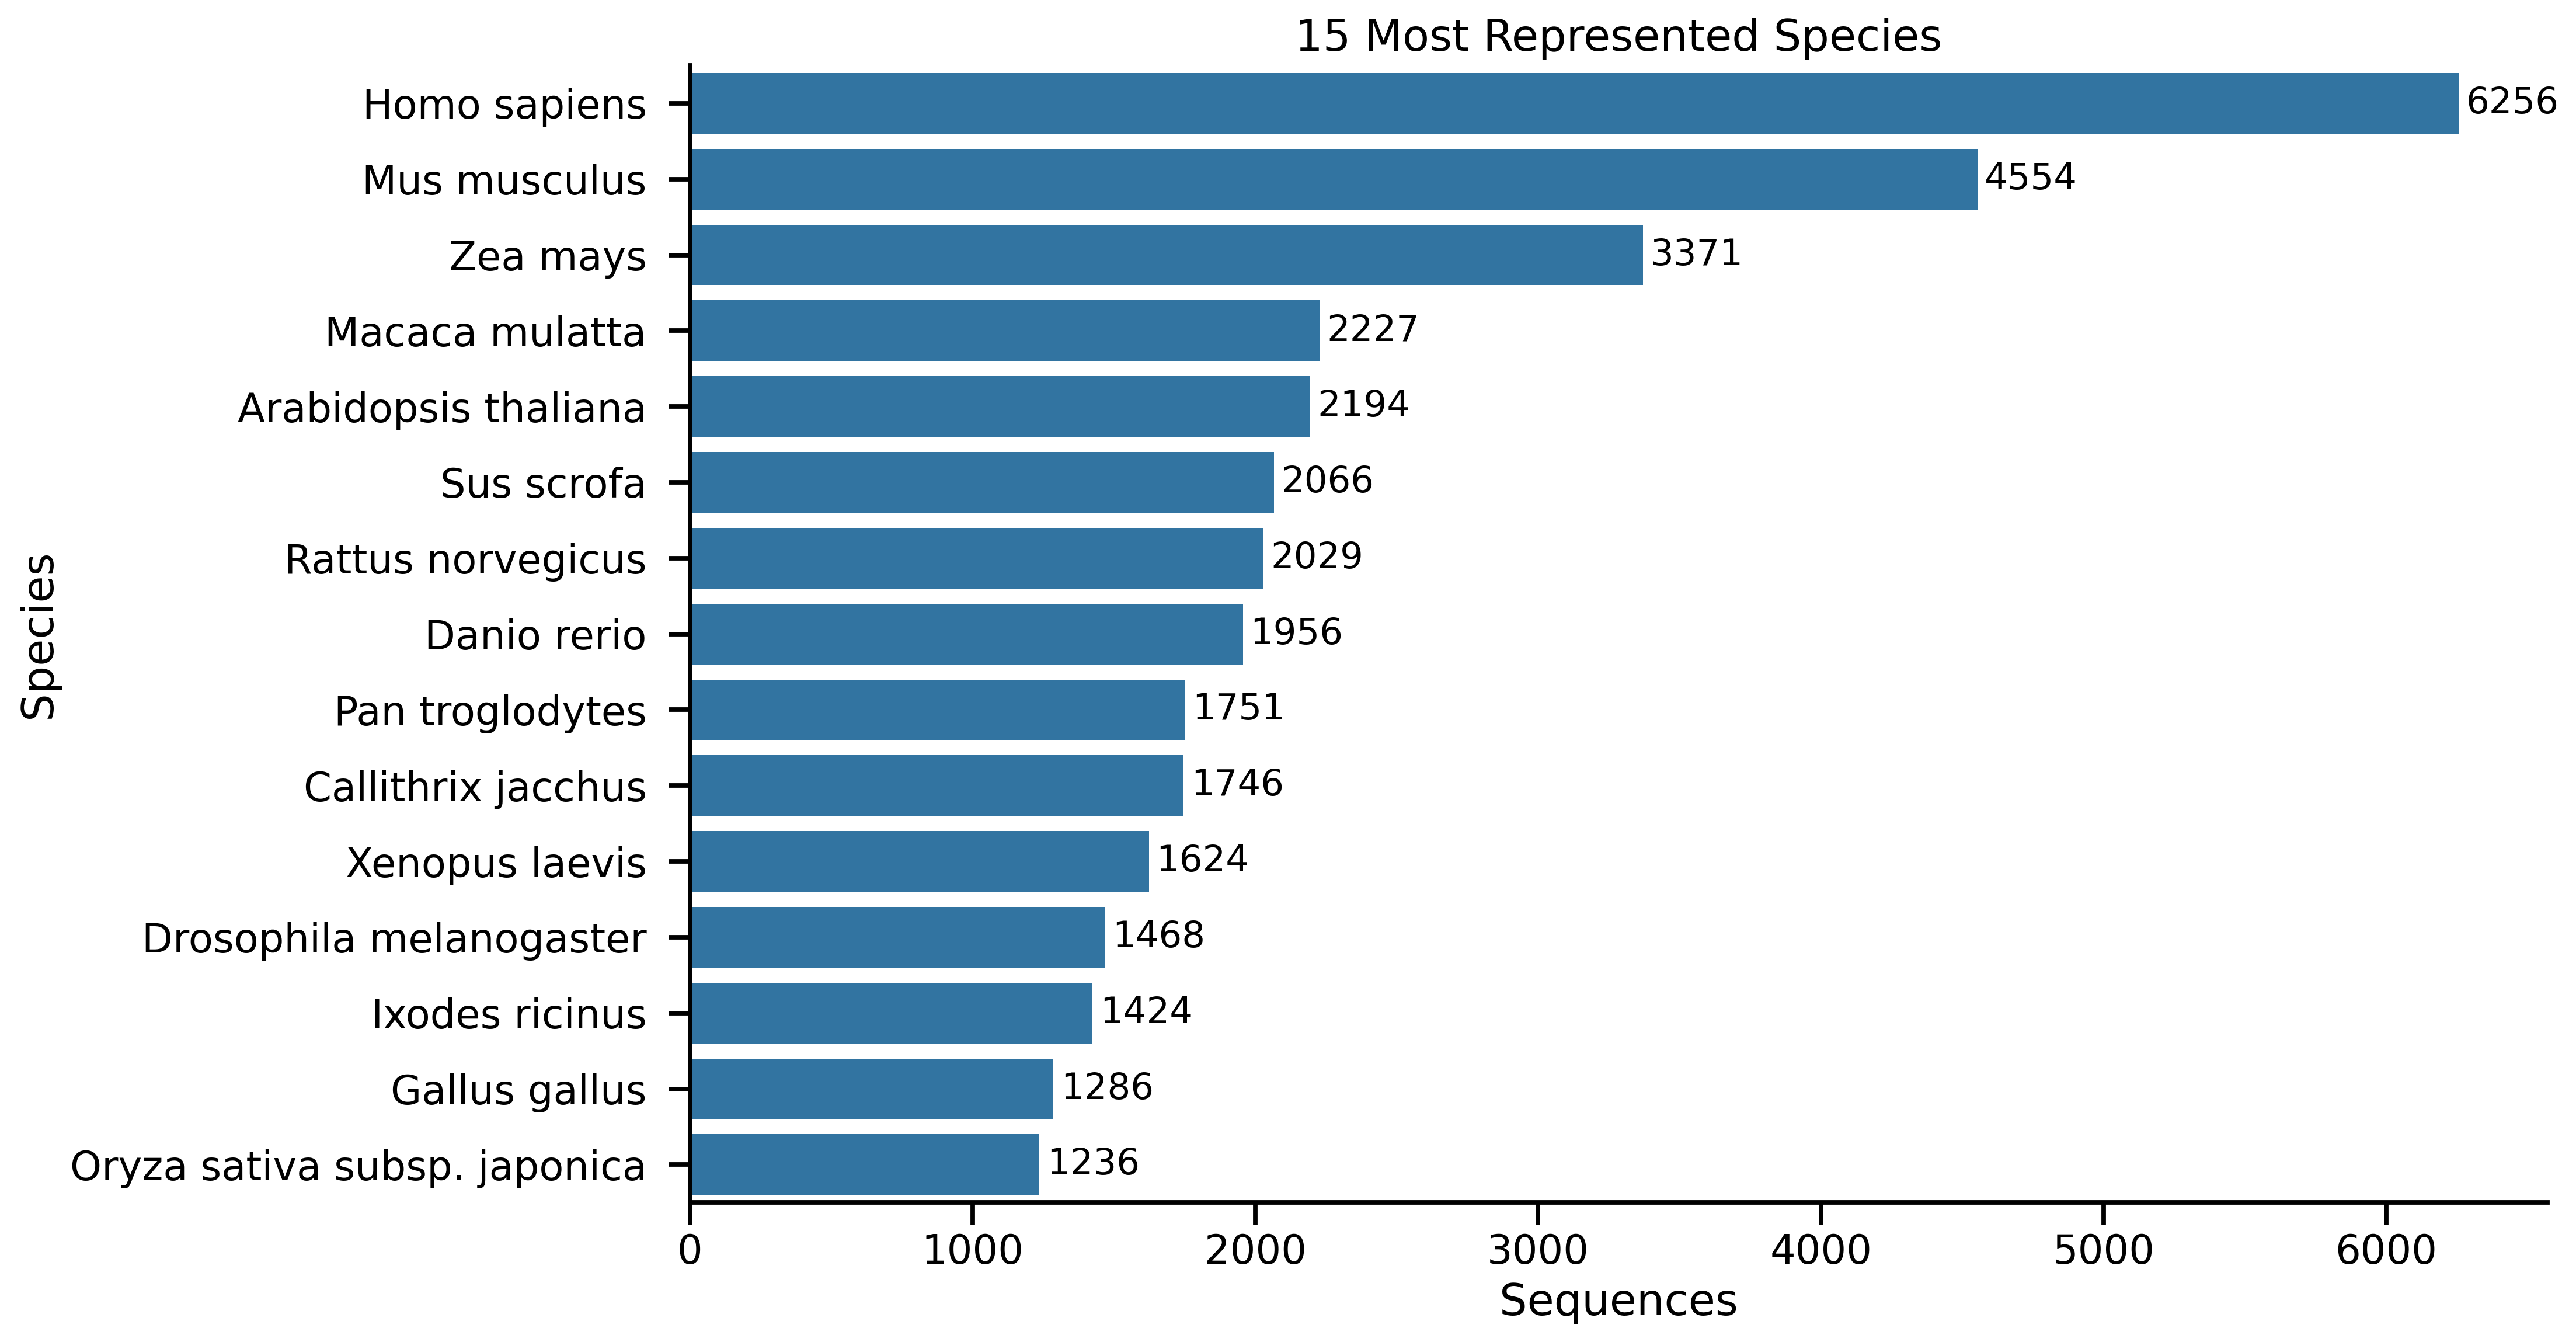

In [42]:
sns.set_context('talk')

counts = seqs_with_codes["Organism"].value_counts().head(15)

plt.figure(figsize=(15, 8), dpi = 300)
ax = sns.barplot(
    y=counts.index,
    x=counts.values, color = sns.color_palette('tab10')[0]
)

# Set log scale for x-axis

# Remove top and right spines
sns.despine()

# Add labels at the end of each bar
for container in ax.containers:
    ax.bar_label(container, labels=[f"{int(v)}" for v in container.datavalues],
                 label_type='edge', fontsize='small', padding=3)

# Axis labels
plt.xlabel("Sequences")
plt.ylabel("")
plt.title("15 Most Represented Species")
plt.ylabel("Species")

plt.tight_layout()
plt.show()


# Are sequences diverse?

In [ ]:
clusters = pd.read_csv("../output/mmseqs/IP_DB_clu.tsv", sep = "\t", header = None)
clusters

,0,1
0,A0A0P0WV74,A0A0P0WV74
1,P31503,P31503
2,P31503,P16143
3,P31503,E9Q6Z8
4,P31503,A0A0A0MQM6
...,...,...
137431,G5B7M9,A0AAX6S0N3
137432,G5B7M9,A0AAX6S1G0
137433,G5B7M9,F7H422
137434,G5B7M9,A0A2K5CJ38


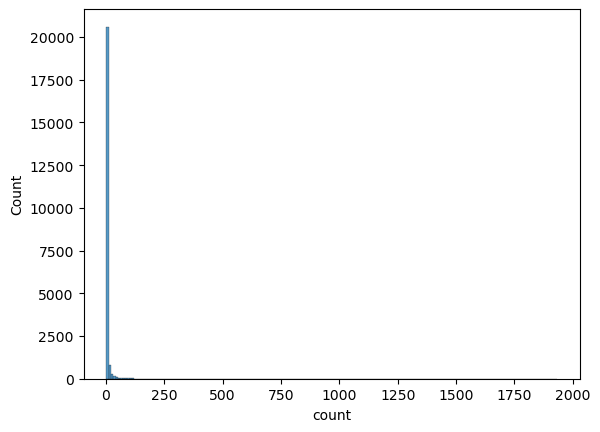

In [9]:
ax = sns.histplot(clusters[0].value_counts(), binwidth = 10)